# Computation of NPP signal to noise ratio in 30 year windows

### UKESM model output

Steps:
- Load the data
- Define the signal to noise function
- Using a 30 year moving window (for loop) to calculate the signal:noise ratio at each grid cell at each year

**Import packages**

In [1]:
!pwd

import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.cm as cm


/home/users/train013/CMIP6_hackathon


**Import the pre-processed data**

In [3]:
data = nc.Dataset('/gws/pw/j05/cop26_hackathons/bristol/project09/data/ETOPO_intpp_Omon_UKESM1-0-LL_historical_r1i1p1f2_185001-201412_yearmonths.nc')
hist_npp = data.variables['intpp'][...]*86400*12  # convert from mol m-2 s-1 --> g m-2 s-1
data = nc.Dataset('/gws/pw/j05/cop26_hackathons/bristol/project09/data/ETOPO_intpp_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_2015001-210012_yearmonths.nc')
ssp585_npp = data.variables['intpp'][...]*86400*12  # convert from mol m-2 s-1 --> g m-2 s-1

lon = data.variables['ETOPO60X'][...]
lat = data.variables['ETOPO60Y'][...]
month = data.variables['time'][...]

print(np.shape(hist_npp))
print(np.shape(ssp585_npp))
print(np.shape(lon))
print(np.shape(lat))
print(np.shape(month))


(165, 12, 180, 360)
(86, 12, 180, 360)
(360,)
(180,)
(12,)


**Put the historical and SSP585 scenario together into one time series and separate into months**

In [4]:
npp = np.ma.concatenate((hist_npp, ssp585_npp), axis=0)
print(np.shape(npp))
years = np.arange(1850.5,2100.6,1)

npp_jan = npp[:,0,:,:]
npp_feb = npp[:,1,:,:]
npp_mar = npp[:,2,:,:]
npp_apr = npp[:,3,:,:]
npp_may = npp[:,4,:,:]
npp_jun = npp[:,5,:,:]
npp_jul = npp[:,6,:,:]
npp_aug = npp[:,7,:,:]
npp_sep = npp[:,8,:,:]
npp_oct = npp[:,9,:,:]
npp_nov = npp[:,10,:,:]
npp_dec = npp[:,11,:,:]

(251, 12, 180, 360)


**Define signal:noise function**

In [5]:
def signal_to_noise(ny,data):
    # find linear trend
    mask = np.ma.getmask(data[0])
    tre = data[1::] - data[0:-1]
    trend = np.ma.average(tre, axis=0)
    # find noise from the error around the linear trend
    vector = np.arange(1,ny+1,1)
    scaler = np.ones(np.shape(trend)) * vector[0, np.newaxis, np.newaxis]
    error = (trend * scaler + data[0]) - data
    noise = np.ma.std(error)
    s2n = (ny*trend) / noise
    return np.ma.masked_where(mask,s2n)


**Calculate the signal:noise ratio using a 30-year moving window**

In [6]:
# define new arrays to fill
s2n_npp_jan = np.ma.zeros(np.ma.shape(npp_jan))
s2n_npp_feb = np.ma.zeros(np.ma.shape(npp_feb))
s2n_npp_mar = np.ma.zeros(np.ma.shape(npp_mar))
s2n_npp_apr = np.ma.zeros(np.ma.shape(npp_apr))
s2n_npp_may = np.ma.zeros(np.ma.shape(npp_may))
s2n_npp_jun = np.ma.zeros(np.ma.shape(npp_jun))
s2n_npp_jul = np.ma.zeros(np.ma.shape(npp_jul))
s2n_npp_aug = np.ma.zeros(np.ma.shape(npp_aug))
s2n_npp_sep = np.ma.zeros(np.ma.shape(npp_sep))
s2n_npp_oct = np.ma.zeros(np.ma.shape(npp_oct))
s2n_npp_nov = np.ma.zeros(np.ma.shape(npp_nov))
s2n_npp_dec = np.ma.zeros(np.ma.shape(npp_dec))

# iterate over all years (vectorised version)
for yr,year in enumerate(years):
    
    # define end year
    ny = 30
    yr2 = yr+ny
    
    # Only do the signal
    if (year+ny > 2100):
        print("end")
        break
    else:
        s2n_npp_jan[yr,:,:] = signal_to_noise(ny,npp_jan[yr:yr2,:,:])
        s2n_npp_feb[yr,:,:] = signal_to_noise(ny,npp_feb[yr:yr2,:,:])
        s2n_npp_mar[yr,:,:] = signal_to_noise(ny,npp_mar[yr:yr2,:,:])
        s2n_npp_apr[yr,:,:] = signal_to_noise(ny,npp_apr[yr:yr2,:,:])
        s2n_npp_may[yr,:,:] = signal_to_noise(ny,npp_may[yr:yr2,:,:])
        s2n_npp_jun[yr,:,:] = signal_to_noise(ny,npp_jun[yr:yr2,:,:])
        s2n_npp_jul[yr,:,:] = signal_to_noise(ny,npp_jul[yr:yr2,:,:])
        s2n_npp_aug[yr,:,:] = signal_to_noise(ny,npp_aug[yr:yr2,:,:])
        s2n_npp_sep[yr,:,:] = signal_to_noise(ny,npp_sep[yr:yr2,:,:])
        s2n_npp_oct[yr,:,:] = signal_to_noise(ny,npp_oct[yr:yr2,:,:])
        s2n_npp_nov[yr,:,:] = signal_to_noise(ny,npp_nov[yr:yr2,:,:])
        s2n_npp_dec[yr,:,:] = signal_to_noise(ny,npp_dec[yr:yr2,:,:])


end


**Have a look at the output**

(1850.0, 2070.0)

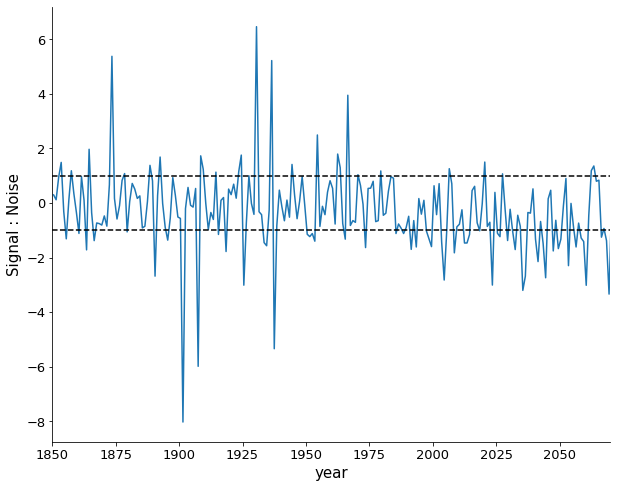

In [7]:
fstic = 13
fslab = 15

fig = plt.figure(figsize=(10,8))
gs = GridSpec(1,1)

la = 90
lo = 180

ax1 = plt.subplot(gs[0])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)
plt.plot(years,s2n_npp_jan[:,la,lo])
plt.plot((1850,2100),(-1,-1),'k--')
plt.plot((1850,2100),(1,1),'k--')
plt.ylabel('Signal : Noise', fontsize=fslab)
plt.xlabel('year', fontsize=fslab)
plt.xlim(1850,2070)

**Import the heatmap of Arctic Tern area use**

In [8]:
data = nc.Dataset('/gws/pw/j05/cop26_hackathons/bristol/project09/tern_heatmap/bird_heatmap.nc')
tern_density = data.variables['density'][...]
tern_lon = data.variables['longitude'][...]
tern_lat = data.variables['latitude'][...]
print(np.shape(tern_density))

tern_lon = np.ma.concatenate((tern_lon[:,200::], tern_lon[:,0:200]+360.0), axis=1)
tern_density = np.ma.concatenate((tern_density[:,200::], tern_density[:,0:200]), axis=1)



(180, 360)


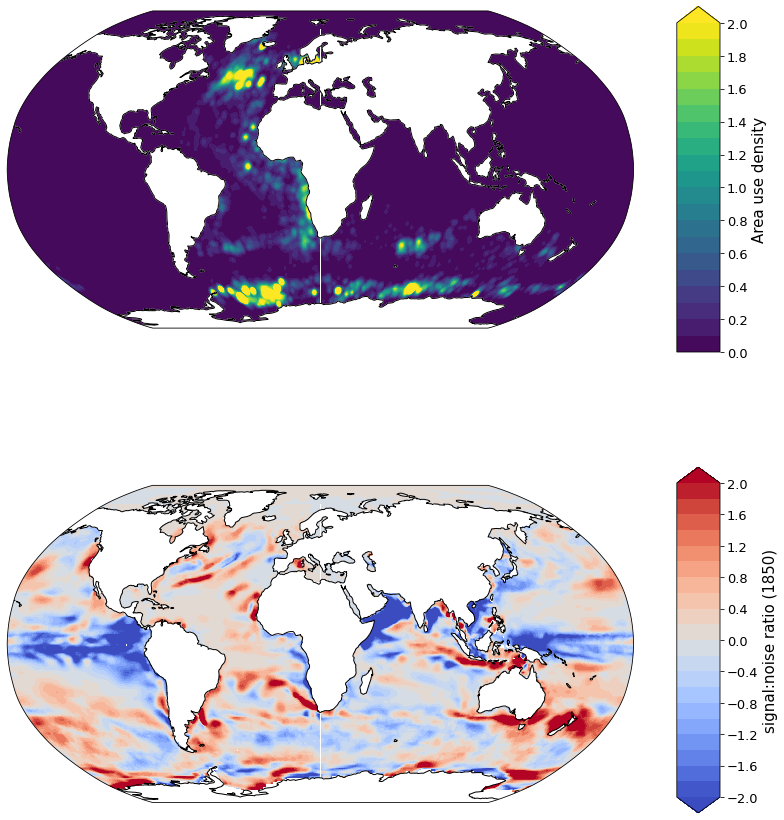

In [9]:
#proj = ccrs.Orthographic(central_longitude=-20.0, central_latitude=0.0, globe=None)
proj = ccrs.Robinson(central_longitude=20)

levs1 = np.arange(0,21,1)*0.1
levs2 = np.arange(-20,21,2)*0.1

colmap1 = cm.viridis
colmap2 = cm.coolwarm

fstic = 13
fslab = 15

fig = plt.figure(figsize=(12,16))
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0], projection=proj)
p1 = plt.contourf(tern_lon, tern_lat, tern_density, transform=ccrs.PlateCarree(), cmap=colmap1, levels=levs1, vmin=np.min(levs1), vmax=np.max(levs1), extend='max')
#c1 = plt.contour(lon, lat, s2n_npp_jan[0,:,:], transform=ccrs.PlateCarree(), colors='k', linewidths=0.75, levels=[-1,1])
ax1.add_feature(cfeature.LAND, color='w', zorder=2)
ax1.coastlines(zorder=2)

ax2 = plt.subplot(gs[1], projection=proj)
p2 = plt.contourf(lon, lat, s2n_npp_jan[0,:,:], transform=ccrs.PlateCarree(), cmap=colmap2, levels=levs2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')
#c1 = plt.contour(lon, lat, s2n_npp_jan[0,:,:], transform=ccrs.PlateCarree(), colors='k', linewidths=0.75, levels=[-1,1])
#ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax2.coastlines(zorder=2)


plt.subplots_adjust(right=0.85)

cbax1 = fig.add_axes([0.9, 0.55, 0.05, 0.3])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel('Area use density', fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

cbax2 = fig.add_axes([0.9, 0.15, 0.05, 0.3])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::2])
cbar2.ax.set_ylabel('signal:noise ratio (1850)', fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)

fig.savefig('TernDensity_UKESMintpp_Signal2Noise1850.png', dpi=300, bbox_inches='tight')

**Extract the signal:noise using the tern heatmap**

In [178]:
### select certain regions

mask = np.ma.getmask(s2n_npp_jan[:,:,:])

la1 = 125; la2 = 155
lo1 = 250; lo2 = 330
print("longitude =",lon[lo1],lon[lo2])
print("latitude =",lat[la1],lat[la2])
mask_NA = mask[:,la1:la2,lo1:lo2]
tern_density_NA = np.ma.masked_where(mask_NA[0,:,:], tern_density[la1:la2,lo1:lo2])
s2n_npp_jan_NA = np.ma.masked_where(mask_NA, s2n_npp_jan[:,la1:la2,lo1:lo2])
s2n_npp_feb_NA = np.ma.masked_where(mask_NA, s2n_npp_feb[:,la1:la2,lo1:lo2])
s2n_npp_mar_NA = np.ma.masked_where(mask_NA, s2n_npp_mar[:,la1:la2,lo1:lo2])
s2n_npp_apr_NA = np.ma.masked_where(mask_NA, s2n_npp_apr[:,la1:la2,lo1:lo2])
s2n_npp_may_NA = np.ma.masked_where(mask_NA, s2n_npp_may[:,la1:la2,lo1:lo2])
s2n_npp_jun_NA = np.ma.masked_where(mask_NA, s2n_npp_jun[:,la1:la2,lo1:lo2])
s2n_npp_jul_NA = np.ma.masked_where(mask_NA, s2n_npp_jul[:,la1:la2,lo1:lo2])
s2n_npp_aug_NA = np.ma.masked_where(mask_NA, s2n_npp_aug[:,la1:la2,lo1:lo2])
s2n_npp_sep_NA = np.ma.masked_where(mask_NA, s2n_npp_sep[:,la1:la2,lo1:lo2])
s2n_npp_oct_NA = np.ma.masked_where(mask_NA, s2n_npp_oct[:,la1:la2,lo1:lo2])
s2n_npp_nov_NA = np.ma.masked_where(mask_NA, s2n_npp_nov[:,la1:la2,lo1:lo2])
s2n_npp_dec_NA = np.ma.masked_where(mask_NA, s2n_npp_dec[:,la1:la2,lo1:lo2])

la1 = 50; la2 = 90
lo1 = 330; lo2 = 360
print("longitude =",lon[lo1],lon[lo2-1])
print("latitude =",lat[la1],lat[la2-1])
mask_BE = mask[:,la1:la2,lo1:lo2]
tern_density_BE = np.ma.masked_where(mask_BE[0,:,:], tern_density[la1:la2,lo1:lo2])
s2n_npp_jan_BE = np.ma.masked_where(mask_BE, s2n_npp_jan[:,la1:la2,lo1:lo2])
s2n_npp_feb_BE = np.ma.masked_where(mask_BE, s2n_npp_feb[:,la1:la2,lo1:lo2])
s2n_npp_mar_BE = np.ma.masked_where(mask_BE, s2n_npp_mar[:,la1:la2,lo1:lo2])
s2n_npp_apr_BE = np.ma.masked_where(mask_BE, s2n_npp_apr[:,la1:la2,lo1:lo2])
s2n_npp_may_BE = np.ma.masked_where(mask_BE, s2n_npp_may[:,la1:la2,lo1:lo2])
s2n_npp_jun_BE = np.ma.masked_where(mask_BE, s2n_npp_jun[:,la1:la2,lo1:lo2])
s2n_npp_jul_BE = np.ma.masked_where(mask_BE, s2n_npp_jul[:,la1:la2,lo1:lo2])
s2n_npp_aug_BE = np.ma.masked_where(mask_BE, s2n_npp_aug[:,la1:la2,lo1:lo2])
s2n_npp_sep_BE = np.ma.masked_where(mask_BE, s2n_npp_sep[:,la1:la2,lo1:lo2])
s2n_npp_oct_BE = np.ma.masked_where(mask_BE, s2n_npp_oct[:,la1:la2,lo1:lo2])
s2n_npp_nov_BE = np.ma.masked_where(mask_BE, s2n_npp_nov[:,la1:la2,lo1:lo2])
s2n_npp_dec_BE = np.ma.masked_where(mask_BE, s2n_npp_dec[:,la1:la2,lo1:lo2])

la1 = 35; la2 = 70
lo1 = 30; lo2 = 80
print("longitude =",lon[lo1],lon[lo2-1])
print("latitude =",lat[la1],lat[la2-1])
mask_AI = mask[:,la1:la2,lo1:lo2]
tern_density_AI = np.ma.masked_where(mask_AI[0,:,:], tern_density[la1:la2,lo1:lo2])
s2n_npp_jan_AI = np.ma.masked_where(mask_AI, s2n_npp_jan[:,la1:la2,lo1:lo2])
s2n_npp_feb_AI = np.ma.masked_where(mask_AI, s2n_npp_feb[:,la1:la2,lo1:lo2])
s2n_npp_mar_AI = np.ma.masked_where(mask_AI, s2n_npp_mar[:,la1:la2,lo1:lo2])
s2n_npp_apr_AI = np.ma.masked_where(mask_AI, s2n_npp_apr[:,la1:la2,lo1:lo2])
s2n_npp_may_AI = np.ma.masked_where(mask_AI, s2n_npp_may[:,la1:la2,lo1:lo2])
s2n_npp_jun_AI = np.ma.masked_where(mask_AI, s2n_npp_jun[:,la1:la2,lo1:lo2])
s2n_npp_jul_AI = np.ma.masked_where(mask_AI, s2n_npp_jul[:,la1:la2,lo1:lo2])
s2n_npp_aug_AI = np.ma.masked_where(mask_AI, s2n_npp_aug[:,la1:la2,lo1:lo2])
s2n_npp_sep_AI = np.ma.masked_where(mask_AI, s2n_npp_sep[:,la1:la2,lo1:lo2])
s2n_npp_oct_AI = np.ma.masked_where(mask_AI, s2n_npp_oct[:,la1:la2,lo1:lo2])
s2n_npp_nov_AI = np.ma.masked_where(mask_AI, s2n_npp_nov[:,la1:la2,lo1:lo2])
s2n_npp_dec_AI = np.ma.masked_where(mask_AI, s2n_npp_dec[:,la1:la2,lo1:lo2])

la1 = 0; la2 = 35
lo1 = 0; lo2 = 360
print("longitude =",lon[lo1],lon[lo2-1])
print("latitude =",lat[la1],lat[la2-1])
mask_SO = mask[:,la1:la2,lo1:lo2]
tern_density_SO = np.ma.masked_where(mask_SO[0,:,:], tern_density[la1:la2,lo1:lo2])
s2n_npp_jan_SO = np.ma.masked_where(mask_SO, s2n_npp_jan[:,la1:la2,lo1:lo2])
s2n_npp_feb_SO = np.ma.masked_where(mask_SO, s2n_npp_feb[:,la1:la2,lo1:lo2])
s2n_npp_mar_SO = np.ma.masked_where(mask_SO, s2n_npp_mar[:,la1:la2,lo1:lo2])
s2n_npp_apr_SO = np.ma.masked_where(mask_SO, s2n_npp_apr[:,la1:la2,lo1:lo2])
s2n_npp_may_SO = np.ma.masked_where(mask_SO, s2n_npp_may[:,la1:la2,lo1:lo2])
s2n_npp_jun_SO = np.ma.masked_where(mask_SO, s2n_npp_jun[:,la1:la2,lo1:lo2])
s2n_npp_jul_SO = np.ma.masked_where(mask_SO, s2n_npp_jul[:,la1:la2,lo1:lo2])
s2n_npp_aug_SO = np.ma.masked_where(mask_SO, s2n_npp_aug[:,la1:la2,lo1:lo2])
s2n_npp_sep_SO = np.ma.masked_where(mask_SO, s2n_npp_sep[:,la1:la2,lo1:lo2])
s2n_npp_oct_SO = np.ma.masked_where(mask_SO, s2n_npp_oct[:,la1:la2,lo1:lo2])
s2n_npp_nov_SO = np.ma.masked_where(mask_SO, s2n_npp_nov[:,la1:la2,lo1:lo2])
s2n_npp_dec_SO = np.ma.masked_where(mask_SO, s2n_npp_dec[:,la1:la2,lo1:lo2])

print(np.shape(s2n_npp_dec_SO))

longitude = 270.5 350.5
latitude = 35.5 65.5
longitude = 350.5 379.5
latitude = -39.5 -0.5
longitude = 50.5 99.5
latitude = -54.5 -20.5
longitude = 20.5 379.5
latitude = -89.5 -55.5
(251, 35, 360)


In [179]:
### weightings
def weighting(data,density):
    ww = density / np.ma.sum(density)
    tmp1 = data * ww
    data_w = np.ma.sum(tmp1)
    return data_w

s2n_npp_jan_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_feb_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_mar_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_apr_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_may_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_jun_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_jul_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_aug_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_sep_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_oct_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_nov_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))
s2n_npp_dec_NA_weighted = np.ma.zeros(len(s2n_npp_jan_NA[:,0,0]))

s2n_npp_jan_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_feb_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_mar_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_apr_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_may_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_jun_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_jul_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_aug_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_sep_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_oct_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_nov_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))
s2n_npp_dec_BE_weighted = np.ma.zeros(len(s2n_npp_jan_BE[:,0,0]))

s2n_npp_jan_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_feb_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_mar_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_apr_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_may_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_jun_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_jul_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_aug_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_sep_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_oct_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_nov_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))
s2n_npp_dec_AI_weighted = np.ma.zeros(len(s2n_npp_jan_AI[:,0,0]))

s2n_npp_jan_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_feb_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_mar_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_apr_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_may_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_jun_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_jul_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_aug_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_sep_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_oct_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_nov_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))
s2n_npp_dec_SO_weighted = np.ma.zeros(len(s2n_npp_jan_SO[:,0,0]))


print(len(s2n_npp_jan_NA_weighted))


for yr in np.arange(len(s2n_npp_jan_NA[:,0,0])):
    s2n_npp_jan_NA_weighted[yr] = weighting(s2n_npp_jan_NA[yr,:,:], tern_density_NA)
    s2n_npp_feb_NA_weighted[yr] = weighting(s2n_npp_feb_NA[yr,:,:], tern_density_NA)
    s2n_npp_mar_NA_weighted[yr] = weighting(s2n_npp_mar_NA[yr,:,:], tern_density_NA)
    s2n_npp_apr_NA_weighted[yr] = weighting(s2n_npp_apr_NA[yr,:,:], tern_density_NA)
    s2n_npp_may_NA_weighted[yr] = weighting(s2n_npp_may_NA[yr,:,:], tern_density_NA)
    s2n_npp_jun_NA_weighted[yr] = weighting(s2n_npp_jun_NA[yr,:,:], tern_density_NA)
    s2n_npp_jul_NA_weighted[yr] = weighting(s2n_npp_jul_NA[yr,:,:], tern_density_NA)
    s2n_npp_aug_NA_weighted[yr] = weighting(s2n_npp_aug_NA[yr,:,:], tern_density_NA)
    s2n_npp_sep_NA_weighted[yr] = weighting(s2n_npp_sep_NA[yr,:,:], tern_density_NA)
    s2n_npp_oct_NA_weighted[yr] = weighting(s2n_npp_oct_NA[yr,:,:], tern_density_NA)
    s2n_npp_nov_NA_weighted[yr] = weighting(s2n_npp_nov_NA[yr,:,:], tern_density_NA)
    s2n_npp_dec_NA_weighted[yr] = weighting(s2n_npp_dec_NA[yr,:,:], tern_density_NA)
    
    s2n_npp_jan_BE_weighted[yr] = weighting(s2n_npp_jan_BE[yr,:,:], tern_density_BE)
    s2n_npp_feb_BE_weighted[yr] = weighting(s2n_npp_feb_BE[yr,:,:], tern_density_BE)
    s2n_npp_mar_BE_weighted[yr] = weighting(s2n_npp_mar_BE[yr,:,:], tern_density_BE)
    s2n_npp_apr_BE_weighted[yr] = weighting(s2n_npp_apr_BE[yr,:,:], tern_density_BE)
    s2n_npp_may_BE_weighted[yr] = weighting(s2n_npp_may_BE[yr,:,:], tern_density_BE)
    s2n_npp_jun_BE_weighted[yr] = weighting(s2n_npp_jun_BE[yr,:,:], tern_density_BE)
    s2n_npp_jul_BE_weighted[yr] = weighting(s2n_npp_jul_BE[yr,:,:], tern_density_BE)
    s2n_npp_aug_BE_weighted[yr] = weighting(s2n_npp_aug_BE[yr,:,:], tern_density_BE)
    s2n_npp_sep_BE_weighted[yr] = weighting(s2n_npp_sep_BE[yr,:,:], tern_density_BE)
    s2n_npp_oct_BE_weighted[yr] = weighting(s2n_npp_oct_BE[yr,:,:], tern_density_BE)
    s2n_npp_nov_BE_weighted[yr] = weighting(s2n_npp_nov_BE[yr,:,:], tern_density_BE)
    s2n_npp_dec_BE_weighted[yr] = weighting(s2n_npp_dec_BE[yr,:,:], tern_density_BE)
    
    s2n_npp_jan_AI_weighted[yr] = weighting(s2n_npp_jan_AI[yr,:,:], tern_density_AI)
    s2n_npp_feb_AI_weighted[yr] = weighting(s2n_npp_feb_AI[yr,:,:], tern_density_AI)
    s2n_npp_mar_AI_weighted[yr] = weighting(s2n_npp_mar_AI[yr,:,:], tern_density_AI)
    s2n_npp_apr_AI_weighted[yr] = weighting(s2n_npp_apr_AI[yr,:,:], tern_density_AI)
    s2n_npp_may_AI_weighted[yr] = weighting(s2n_npp_may_AI[yr,:,:], tern_density_AI)
    s2n_npp_jun_AI_weighted[yr] = weighting(s2n_npp_jun_AI[yr,:,:], tern_density_AI)
    s2n_npp_jul_AI_weighted[yr] = weighting(s2n_npp_jul_AI[yr,:,:], tern_density_AI)
    s2n_npp_aug_AI_weighted[yr] = weighting(s2n_npp_aug_AI[yr,:,:], tern_density_AI)
    s2n_npp_sep_AI_weighted[yr] = weighting(s2n_npp_sep_AI[yr,:,:], tern_density_AI)
    s2n_npp_oct_AI_weighted[yr] = weighting(s2n_npp_oct_AI[yr,:,:], tern_density_AI)
    s2n_npp_nov_AI_weighted[yr] = weighting(s2n_npp_nov_AI[yr,:,:], tern_density_AI)
    s2n_npp_dec_AI_weighted[yr] = weighting(s2n_npp_dec_AI[yr,:,:], tern_density_AI)
    
    s2n_npp_jan_SO_weighted[yr] = weighting(s2n_npp_jan_SO[yr,:,:], tern_density_SO)
    s2n_npp_feb_SO_weighted[yr] = weighting(s2n_npp_feb_SO[yr,:,:], tern_density_SO)
    s2n_npp_mar_SO_weighted[yr] = weighting(s2n_npp_mar_SO[yr,:,:], tern_density_SO)
    s2n_npp_apr_SO_weighted[yr] = weighting(s2n_npp_apr_SO[yr,:,:], tern_density_SO)
    s2n_npp_may_SO_weighted[yr] = weighting(s2n_npp_may_SO[yr,:,:], tern_density_SO)
    s2n_npp_jun_SO_weighted[yr] = weighting(s2n_npp_jun_SO[yr,:,:], tern_density_SO)
    s2n_npp_jul_SO_weighted[yr] = weighting(s2n_npp_jul_SO[yr,:,:], tern_density_SO)
    s2n_npp_aug_SO_weighted[yr] = weighting(s2n_npp_aug_SO[yr,:,:], tern_density_SO)
    s2n_npp_sep_SO_weighted[yr] = weighting(s2n_npp_sep_SO[yr,:,:], tern_density_SO)
    s2n_npp_oct_SO_weighted[yr] = weighting(s2n_npp_oct_SO[yr,:,:], tern_density_SO)
    s2n_npp_nov_SO_weighted[yr] = weighting(s2n_npp_nov_SO[yr,:,:], tern_density_SO)
    s2n_npp_dec_SO_weighted[yr] = weighting(s2n_npp_dec_SO[yr,:,:], tern_density_SO)


### put it all together in easy to use arrays
s2n_npp_NA_weighted = np.vstack((s2n_npp_jan_NA_weighted, s2n_npp_feb_NA_weighted, s2n_npp_mar_NA_weighted, 
                                 s2n_npp_apr_NA_weighted, s2n_npp_may_NA_weighted, s2n_npp_jun_NA_weighted, 
                                 s2n_npp_jul_NA_weighted, s2n_npp_aug_NA_weighted, s2n_npp_sep_NA_weighted, 
                                 s2n_npp_oct_NA_weighted, s2n_npp_nov_NA_weighted, s2n_npp_dec_NA_weighted))
s2n_npp_BE_weighted = np.vstack((s2n_npp_jan_BE_weighted, s2n_npp_feb_BE_weighted, s2n_npp_mar_BE_weighted,
                                 s2n_npp_apr_BE_weighted, s2n_npp_may_BE_weighted, s2n_npp_jun_BE_weighted,
                                 s2n_npp_jul_BE_weighted, s2n_npp_aug_BE_weighted, s2n_npp_sep_BE_weighted,
                                 s2n_npp_oct_BE_weighted, s2n_npp_nov_BE_weighted, s2n_npp_dec_BE_weighted))
s2n_npp_AI_weighted = np.vstack((s2n_npp_jan_AI_weighted, s2n_npp_feb_AI_weighted, s2n_npp_mar_AI_weighted, 
                                 s2n_npp_apr_AI_weighted, s2n_npp_may_AI_weighted, s2n_npp_jun_AI_weighted, 
                                 s2n_npp_jul_AI_weighted, s2n_npp_aug_AI_weighted, s2n_npp_sep_AI_weighted, 
                                 s2n_npp_oct_AI_weighted, s2n_npp_nov_AI_weighted, s2n_npp_dec_AI_weighted))
s2n_npp_SO_weighted = np.vstack((s2n_npp_jan_SO_weighted, s2n_npp_feb_SO_weighted, s2n_npp_mar_SO_weighted, 
                                 s2n_npp_apr_SO_weighted, s2n_npp_may_SO_weighted, s2n_npp_jun_SO_weighted, 
                                 s2n_npp_jul_SO_weighted, s2n_npp_aug_SO_weighted, s2n_npp_sep_SO_weighted, 
                                 s2n_npp_oct_SO_weighted, s2n_npp_nov_SO_weighted, s2n_npp_dec_SO_weighted))
print(np.shape(s2n_npp_NA_weighted))
print(np.shape(s2n_npp_BE_weighted))
print(np.shape(s2n_npp_AI_weighted))
print(np.shape(s2n_npp_SO_weighted))


251
(12, 251)
(12, 251)
(12, 251)
(12, 251)


In [ ]:
xxx

**Plot results**

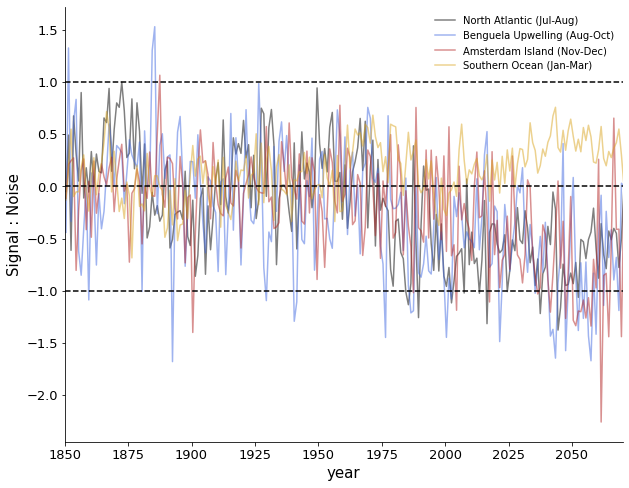

In [182]:
fstic = 13
fslab = 15
alf = [0.5,0.5,0.5,0.5]
ls = ['-','-','-','-']
lw = [1.5,1.5,1.5,1.5]
labs = ['North Atlantic (Jul-Aug)', 
        'Benguela Upwelling (Aug-Oct)',
        'Amsterdam Island (Nov-Dec)',
        'Southern Ocean (Jan-Mar)']
cols = ['k', 'royalblue', 'firebrick', 'goldenrod']

fig = plt.figure(figsize=(10,8))
gs = GridSpec(1,1)

la = 90
lo = 180

ax1 = plt.subplot(gs[0])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)

plt.plot(years, np.average(s2n_npp_NA_weighted[6:8,:],axis=0), color=cols[0], label=labs[0], linewidth=lw[0], alpha=alf[0], linestyle=ls[0])
plt.plot(years, np.average(s2n_npp_BE_weighted[7:10,:],axis=0), color=cols[1], label=labs[1], linewidth=lw[1], alpha=alf[1], linestyle=ls[1])
plt.plot(years, np.average(s2n_npp_AI_weighted[10:12,:],axis=0), color=cols[2], label=labs[2], linewidth=lw[2], alpha=alf[2], linestyle=ls[2])
plt.plot(years, np.average(s2n_npp_SO_weighted[0:4,:],axis=0), color=cols[3], label=labs[3], linewidth=lw[3], alpha=alf[3], linestyle=ls[3])

plt.plot((1850,2100),(0,0),'k--')
plt.plot((1850,2100),(-1,-1),'k--')
plt.plot((1850,2100),(1,1),'k--')

plt.ylabel('Signal : Noise', fontsize=fslab)
plt.xlabel('year', fontsize=fslab)
plt.xlim(1850,2070)

plt.legend(frameon=False, loc='upper right', ncol=1)

fig.savefig('UKESMintpp_Signal2Noise_TernForagingRegions.png', dpi=300, bbox_inches='tight')